<a href="https://colab.research.google.com/github/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_monte_carlo_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import random, math, sys, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 

from IPython.display import display
from google.colab import files

# Set for animation display
rc('animation', html='jshtml')

# !pip install git+https://github.com/rossant/ipycache.git
# %load_ext ipycache
# %%cache [name of the cache] --force | --read 

# Class for Maze
Used in Dynamic Programming

In [0]:
class Maze:
    LEFT = "←"
    RIGHT = "→"
    UP = "↑"
    DOWN = "↓"
    START = "S"
    GOAL = "G"
    LEFT_DASH = "⇠"
    RIGHT_DASH = "⇢"
    UP_DASH = "⇡"
    DOWN_DASH = "⇣"

    S_START = (3, 0)
    S_GOAL = (5, 8)
    V_START = 1
    V_GOAL = 2
    V_WALL = 3

    FONTSIZE = 18

    REWARD = -1
    REWARD_NEXTGOAL = -1
    # You can also fix the value of Value Function at the goal 
    REWARD_GOAL = 0

    EPSILON = 0.1


    def __init__(self, width=9, height=6):
        self.image = plt.imread(
            "https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning" + 
            "/master/maze_optimal_path/icon/luzhuzhu.png")
        self.shape = (height, width)
        
        self.mkMaze()
        self.initSAP()
        self.mkPlt()

        self.isLearn =False

    def initSAP(self):
        # Initialize states
        gridStates = list(np.ndindex(self.shape))
        self.states = list(np.ndindex(self.shape))
        [self.states.remove(wall) for wall in self.wall_indexlist]

        # Initialize actions
        self.actions = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        self.actionSymbols = dict(zip(self.actions, [self.LEFT, self.RIGHT, self.UP, self.DOWN]))
        self.actionSymbolsRev = dict(zip([self.LEFT, self.RIGHT, self.UP, self.DOWN], self.actions))
        self.actionSymbols_dash = dict(zip(self.actions, [self.LEFT_DASH, self.RIGHT_DASH, self.UP_DASH, self.DOWN_DASH]))

        # Initialize policy and value function
        self.value = {}
        self.q = {}
        self.policy = {}
        for s in gridStates:
            self.value[s] = 0
        for s in self.states:
            canActionList = self.supposeAction(s)
            numAction = len(canActionList)
            _isGoal = self.isGoal(s)
            for alist in canActionList:
                a = alist[0]
                # With uniform random action
                self.q[(s,a)] = 0
                self.policy[(s,a)] = 1/numAction #if not _isGoal else 0
        # For off-policy
        self.policyBehavior = self.policy.copy()

    def supposeAction(self, s):
        canActionList = []
        _isGoal = self.isGoal(s)
        for a in self.actions:
            reward = self.REWARD
            s_new = tuple(np.asarray(s) + np.asarray(a)[::-1])
            canAction = s_new in self.states
            canGoal = s_new == self.S_GOAL
            if canAction and canGoal: reward = self.REWARD_NEXTGOAL
            if _isGoal: reward = self.REWARD_GOAL; s_new = self.S_GOAL
            if canAction: canActionList.append([a, reward, s_new])
        return canActionList

    def chooseAction(self, s, policymode="on"):
        isOnpolicy = policymode.lower() == "on"
        policy = self.policy if isOnpolicy else self.policyBehavior
        canActionList = self.supposeAction(s)
        policyActionList = [alist for alist in canActionList]
        policyWeightList = [policy[(s, alist[0])] for alist in canActionList]
        policyAction = random.choices(policyActionList, weights=policyWeightList, k=1)[0]
        return policyAction

    def mkPlt(self):
        # Make a color map of fixed colors
        self.cmap = colors.ListedColormap(["white", "yellow", "grey"])
        bounds=[0.5, 1.5, 2.5, 9.5]
        self.norm = colors.BoundaryNorm(bounds, self.cmap.N)

        # Make new figure and subplot axes
        self.fig, self.axes = plt.subplots(1,2, figsize=(15, 5))
        plt.close()

    def mkMaze(self):
        self.maze = np.zeros(self.shape, dtype=int)

        # Mark location
        self.maze[self.S_START] = self.V_START
        self.maze[self.S_GOAL] = self.V_GOAL

        # Mark wall for maze
        self.maze[2:5,2] = self.V_WALL
        self.maze[1,5] = self.V_WALL
        self.maze[3:6,7] = self.V_WALL

        # Get wall index
        self.wall_index = np.where(self.maze == self.V_WALL)
        self.wall_indexlist = list(zip(self.wall_index[0], self.wall_index[1]))

    def isWall(self, s):
        if self.maze[s] == self.V_WALL:
            return True
        else:
            return False

    def isGoal(self, s):
        if self.maze[s] == self.V_GOAL:
            return True
        else:
            return False 

    def setImage(self, ax, loc):
        im = OffsetImage(self.image, zoom=0.072, resample=True)
        ab = AnnotationBbox(im, loc, xycoords='data', frameon=False, box_alignment=(0.5, 0.5)) 
        ab.set_zorder(1)
        ax.add_artist(ab)

    # Set maze layout for plot
    def setMaze(self, ax):
        argMark = dict(fontsize=self.FONTSIZE, ha="center", va="center")

        # Basic axes setting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("on")
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["right"].set_linewidth(0.5)
        ax.spines["top"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_color("k")
        ax.spines["right"].set_color("k")
        ax.spines["top"].set_color("k")
        ax.spines["bottom"].set_color("k")

        # Plot maze layout
        ax.pcolor(self.maze,snap="true", edgecolors="k", linewidths=0.5, cmap=self.cmap, norm=self.norm)

        # Add mark for start and goal and current location
        loc = (self.S_START[1] + 0.5, self.S_START[0] + 0.5)
        self.setImage(ax, loc)
        ax.text(self.S_START[1] + 0.5, self.S_START[0] + 0.5, self.START, **argMark)
        ax.text(self.S_GOAL[1] + 0.5, self.S_GOAL[0] + 0.5, self.GOAL, **argMark)

        # Prevent auto plot.show() in google colab
        plt.close()

    # Set the possible action according to policy
    def setAction(self, ax):
        actionColor = "deepskyblue"
        argActionLeft = dict(fontsize=self.FONTSIZE, ha="right", va="center", color=actionColor)
        argActionRight = dict(fontsize=self.FONTSIZE, ha="left", va="center", color=actionColor)
        argActionUp = dict(fontsize=self.FONTSIZE, ha="center", va="bottom", color=actionColor)
        argActionDown = dict(fontsize=self.FONTSIZE, ha="center", va="top", color=actionColor)
        argAction = dict(zip(self.actions, [argActionLeft, argActionRight, argActionUp, argActionDown]))

        # Add action directions for all cell
        for s in self.states:
            if self.isGoal(s): continue
            j = s[0] + 0.5
            i = s[1] + 0.5
            for a in self.actions:
                try:
                    policy = self.policy[(s, a)]
                except KeyError:
                    continue
                if policy <= 0: continue
                actionSymbol = self.actionSymbols[a] if policy > self.EPSILON else self.actionSymbols_dash[a]
                arg = argAction[a]
                ax.text(i, j, actionSymbol, **arg)
        plt.close()

    # Set the value of value function for heatmap
    def setValue(self, ax, setq):
        shape = self.shape
        if setq == False:
            value = np.zeros(shape)
            for s in self.value.keys():
                value[s] = self.value[s]
        else:
            shape = tuple(2 * x for x in shape)
            value = np.zeros(shape)
            for (row, col) in self.value.keys():
                a = (row*2+1, row*2)
                b = (col*2, col*2+1)
                c = [(i, j) for j in b for i in a]
                ca = {x:self.actions[i] for i, x in enumerate(c)}
                for c, a in ca.items():
                    try:
                        value[c] = self.q[((row, col), a)]
                    except KeyError:
                        continue

        # Plot heatmap
        pc = ax.pcolor(value, snap="true", edgecolors="w", linewidths=0.5)

        # Add value text for heatmap
        pc.update_scalarmappable()
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            red, green, blue = color[:3]*255
            brightness = (red*0.299 + green*0.587 + blue*0.114) > 180 #186
            color = "k" if brightness else  "w"
            ax.text(x, y, str(round(value, 2)), ha="center", va="center", color=color)
        plt.close()

    # Trigger to draw maze layout, policy and heatmap
    def draw(self, setq=False):
        [ax.cla() for ax in self.axes]
        self.setMaze(self.axes[0])
        self.setAction(self.axes[0])
        self.setValue(self.axes[1], setq) 
        display(self.fig)

    # Get the steps that from start to goal of optimal policy
    def getNumActions(self):
        numActions = 0
        curState=self.S_START
        while True:
            numActions += 1
            nextState = self.chooseAction(curState)[-1]
            curState = nextState
            if curState == self.S_GOAL: return numActions

    # Animate the jerry"s actions in maze
    def animate(self):
        self.fig_ani, self.ax_ani = plt.subplots(1,figsize=(7.5, 5)) 
        self.setMaze(self.ax_ani)
        self.setAction(self.ax_ani)
        if self.isLearn:
            frames = self.getNumActions() + 1
        else:
            frames = 20
        framesSet = frames*5

        self.luzhuzhu = self.ax_ani.artists[0]

        # Reset luzhuzhu"s location
        def resetPos():
            curState = self.S_START
            curPos = tuple(np.add(curState, (0.5, 0.5))[::-1])
            self.luzhuzhu.xyann = curPos

        # Animate
        def setAnimate(i):
            curPos = self.luzhuzhu.xyann
            curState = tuple(np.subtract(curPos, (0.5, 0.5))[::-1])
            if i+1 % frames == 1: 
                resetPos()
                return self.ax_ani,
            else:
                curPos = self.luzhuzhu.xyann
                curState = tuple(np.subtract(curPos, (0.5, 0.5))[::-1])
                curState_int = tuple(int(x) for x in curState)
                nextState = self.chooseAction(curState_int)[-1]
                nextPos = tuple(np.add(nextState, (0.5, 0.5))[::-1])
                self.luzhuzhu.xyann = nextPos
                if curState == self.S_GOAL and nextState == self.S_GOAL:
                    resetPos()
                    return self.ax_ani,
                return self.ax_ani,

        # Call to aniamte
        self.anim = animation.FuncAnimation(self.fig_ani, setAnimate,
                                            frames=framesSet, interval=250, blit=False)
        
        # Option to write animation to mp4 and turn off rc('animation', html='jshtml')
        # writer = animation.writers["ffmpeg"](fps=3)
        # if self.isLearn:
        #     filename = "maze-optimal-path_dynamic-programming_demo_afterLearning.mp4"
        # else:
        #     filename = "maze-optimal-path_dynamic-programming_demo_beforeLearning.mp4"
        # self.anim.save(filename,writer=writer,dpi=300)
        # files.download(filename)

# Class for Maze mini
Used for verification and validation (sampling needs a lot computing resouce, so I need to deploy a simpler case)

In [0]:
class Maze_mini(Maze):
    S_START = (0, 0)
    S_GOAL = (2, 4)

    def __init__(self, width=5, height=3):
        self.image = plt.imread(
            "https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning" + 
            "/master/maze_optimal_path/icon/luzhuzhu.png")
        self.shape = (height, width)
        self.countDraw = 0

        self.mkMaze()
        self.initSAP()
        self.mkPlt()

        self.isLearn =False

    def setImage(self, ax, loc):
        im = OffsetImage(self.image, zoom=0.12, resample=True)
        ab = AnnotationBbox(im, loc, xycoords='data', frameon=False, box_alignment=(0.5, 0.5)) 
        ab.set_zorder(1)
        ax.add_artist(ab)

    def mkMaze(self):
        self.maze = np.zeros(self.shape, dtype=int)

        # Mark location
        self.maze[self.S_START] = self.V_START
        self.maze[self.S_GOAL] = self.V_GOAL

        # Mark wall for maze
        self.maze[0,1] = self.V_WALL
        self.maze[1,3] = self.V_WALL

        # Get wall index
        self.wall_index = np.where(self.maze == self.V_WALL)
        self.wall_indexlist = list(zip(self.wall_index[0], self.wall_index[1]))

# Materials
## On-policy
| Exploring Starts | On-policy ε-soft policies |
|---|---|
|<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_ES.png" width="600"/> | <img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_onpolicy-firstvisit-epsilonsoft.png" width="600"/>|

## Off-policy
| Policy Evaluation | MC Control |
|---|---|
|<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_offpolicy-policyEvaluation.png" width="600"/> | <img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_MonteCarlo_offpolicy-control.png" width="600"/>|

#Hints
- When you reverse the order of episode for loop, G<-gamma*G + R will work for below formula.
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_G_sum.png" width="300"/>
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_G_iteration.png" width="600"/>

-  When you update the policy after one episode or some episodes, you will encounter the dilemma which leads to infinite loop.
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/MazeMini_MC_ES_dilemma.png" width="300"/>

# Class for Monte Carlo Methods



In [0]:
class RL_mc:
    def __init__(self, maze):
        self.maze = maze
        self.mathclose = 1e-5
        self.stepTolerant = self.maze.shape[0] * self.maze.shape[1] * 4
        self.stateStart = self.maze.S_START
        self.dilemma = False

    def generateStart(self, est=False):
        s_start = random.choice(self.maze.states) if est else self.stateStart
        a_start, r_start, s_new = random.choice(self.maze.supposeAction(s_start))
        start = [s_start, a_start, r_start, s_new]
        return start

    def generateEpisode(self, est=False, policymode="on"):
        self.episode = []
        self.path = []
        start = self.generateStart(est)
        self.episode.extend(start)
        self.path.extend(start[::len(start)-1])
        numStep = 0
        while True:
            numStep += 1
            s_tail = self.episode[-1]
            if numStep > self.stepTolerant:
                self.episode = []
                return
            if s_tail == self.maze.S_GOAL: 
                # step = self.maze.chooseAction(s_tail, policymode)
                # self.episode.extend(step)
                self.episode.pop()
                it = iter(self.episode)
                self.episode = list(zip(it, it, it))
                return
            step = self.maze.chooseAction(s_tail, policymode)
            self.episode.extend(step)
            self.path.append(step[-1])

    def updateQP(self, visitmode="first", discount_rate=1.0, epsilon=0, policymode="off", weighted=True, drawstep=False):
        isOnpolicy = policymode.lower() == "on"

        G = 0
        probBehavior = 1
        improtanceRatio = 1
        self.episode.reverse()
        for idx, (s, a, r) in enumerate(self.episode):
            sa = (s, a)
            [x.update({s: 0})
                for x in [self.v] 
                if not s in x.keys()]
            [x.update({sa: 0})
                for x in [self.counterSA, self.q] 
                if not sa in x.keys()]
            visit_idx = list(i for i, step in enumerate(self.episode) if step[0:2] == sa)
            firstVisit_idx = visit_idx[-1]

            G = discount_rate*G + r
            # Skip the non-first visit (state, action)
            if visitmode.lower() == "first" and firstVisit_idx == idx and len(visit_idx) > 1: continue
            self.counterSA[sa] +=  improtanceRatio #if (isOnpolicy or not weighted) else improtanceRatio
            nsa = self.counterSA[sa]
            ns = sum([value for key, value in self.counterSA.items() if key[0] == s])
            self.q[sa] = self.q[sa] + improtanceRatio * (G - self.q[sa]) / nsa
            self.v[s] = self.v[s] + improtanceRatio * (G - self.v[s]) / ns
            self.maze.q.update(self.q)
            self.maze.value.update(self.v)

            # Generate new policy and update
            """Trace set: Draw the episode step by step, use it when debugging or tracing"""
            if drawstep: self.drawEpisode(cur=s)
            salist = [key for key, value in self.maze.policy.items() if key[0] == s]
            q = {key: value for key, value in self.q.items() if key[0] == s}
            qmax_value = max(q.values(), default=0)
            qmax = {key: value 
                    for key, value in q.items() 
                    if math.isclose(value, qmax_value, abs_tol=self.mathclose)}
            policy_new = {key: (1 - epsilon + epsilon/len(salist))/len(qmax) 
                           if key in qmax.keys() else epsilon/len(salist) 
                           for key in salist}
            self.maze.policy.update(policy_new)

            # Update the improtanceRatio
            probBehavior = self.maze.policyBehavior[sa]
            a_policyTarget = self.maze.chooseAction(s)[0]
            if (not isOnpolicy) and (a != a_policyTarget): return
            improtanceRatio *= 1 / probBehavior if not isOnpolicy and weighted else 1

    def learn(self, numEpisode=1, learnmode="off", epsilon=0, drawpath=False, showloop=True, drawmaze=False, **kwarg):
        """
        Arguments:
            numEpisode: number of episodes to try
            learnmode: "on-est", "on-esf", "off". Remained to specify future algorithm.
            epsilon: parameter for epsilon-soft algorithm
            drawpath: flag to draw episode path
            visitmode: "first" default, deploy all visit by non-"first" keyword like "all"
            discount_rate: 1.0 default, discount future reawrd for long turn return
            policymode: derived from learnmode meaning on-policy or off-policy
            weighted: True default, change to False when using ordinary importance smpling
            drawstep: False default, using to show how off-policy backward scan the path tu update
        """
        learnmode = learnmode.lower()
        policymode = learnmode.split("-")[0]
        est = learnmode.split("-")[1] == "est" if policymode == "on" else False
        
        kwarg.update(dict(policymode=policymode, epsilon=epsilon))

        self.counterSA = {}
        self.q = {}
        self.v = {}
        # For agent to decide whether use solid symbol or dash symbol
        self.maze.EPSILON = epsilon

        self.sumq = []
        self.sumv = []
        for i in range(numEpisode):
            if showloop: sys.stdout.write('\rEpisodes: '+str(i+1))

            # Generate episodes and update value function and policy
            self.generateEpisode(est=est, policymode=policymode)
            self.updateQP(**kwarg)

            if drawpath: self.drawEpisode()
            if drawmaze: self.maze.draw()
            q = sum(self.q.values()) #/len(self.q) if len(self.q) != 0 else np.nan
            v = sum(self.v.values()) if len(self.v) != 0 else np.nan
            self.sumq.append(q)
            self.sumv.append(v)

    def drawEpisode(self, cur=(-1,-1)):
        showstep = cur != (-1,-1)
        argMark = dict(fontsize=self.maze.FONTSIZE, ha="center", va="center", color="r")
        verts = [(p[1] + 0.5, p[0] + 0.5) for p in self.path]
        xs, ys = zip(*verts)

        fig_epi, axes = plt.subplots(1, 2, figsize=(15, 5)) 
        ax_epi = axes[0]
        ax_value = axes[1]
        maze.setMaze(ax_epi)
        maze.setAction(ax_epi)
        maze.setValue(ax_value)
        ax_epi.plot(xs, ys, '--', color="purple", alpha=0.7)

        if not showstep:
            ax_epi.text(verts[0][0], verts[0][1], "●", **argMark)
        else:
            ax_epi.text(cur[1] + 0.5, cur[0] + 0.5, "◆", **argMark)

        display(fig_epi)

# Trial of solving Maze
When test, I found the computing sonsumes time when do V&V, so a mini model of Maze is needed for quick check. Actually it doesn't take that much.

## Exploring Start
You can make not bad approximate results from ES under finite episodes compared to Dynamic Progamming showed below [DP github url](https://github.com/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_dynamic_programming.ipynb):
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Maze_DP.png" width="600"/>  
The bigger states space, the more episodes are needed to generate quite good approximation.

Initialize the maze


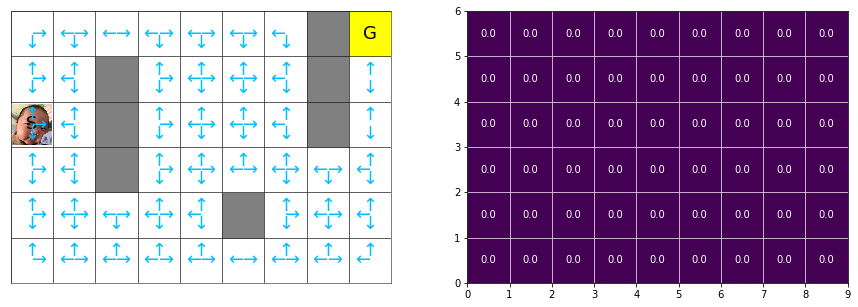

Learning
Episodes: 20000

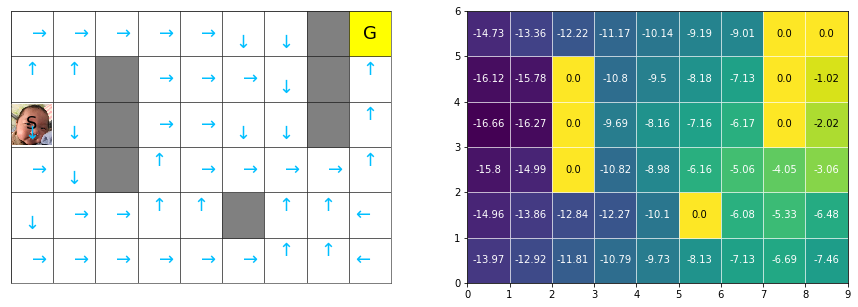

CPU times: user 1min 18s, sys: 1.37 s, total: 1min 19s
Wall time: 1min 19s


In [0]:
%%time

print("Initialize the maze")
maze = Maze()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.learn(numEpisode=20000, learnmode="on-est")
maze.draw()

## On-policy $\epsilon$-soft policies
In on-policy control methods the policy is generally soft, meaning that $\pi(a|s)$
for all $s \in S$ and all $a \in A(s)$, but gradually shifted closer and closer to a deterministic
optimal policy. 

According to the results, the $\epsilon$-soft policies won't perform well like ES method.

Initialize the maze


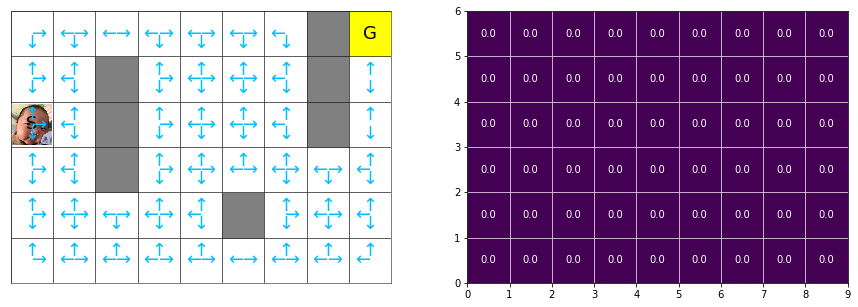

Learning
Episodes: 20000

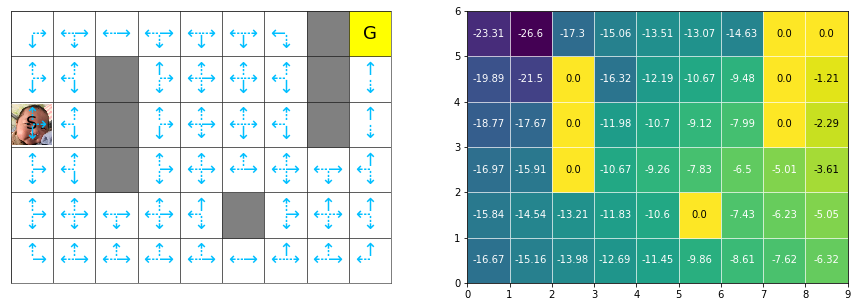

CPU times: user 1min 33s, sys: 1.44 s, total: 1min 34s
Wall time: 1min 34s


In [0]:
%%time

print("Initialize the maze")
maze = Maze()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.learn(numEpisode=20000, learnmode="on-esf", epsilon=0.2)
maze.draw()

## Off-policy

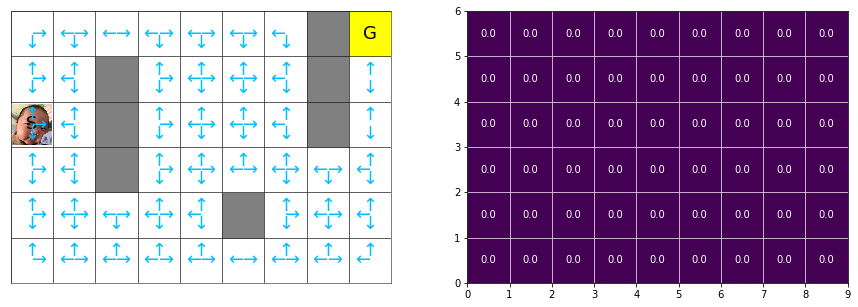

Learning
Episodes: 20000

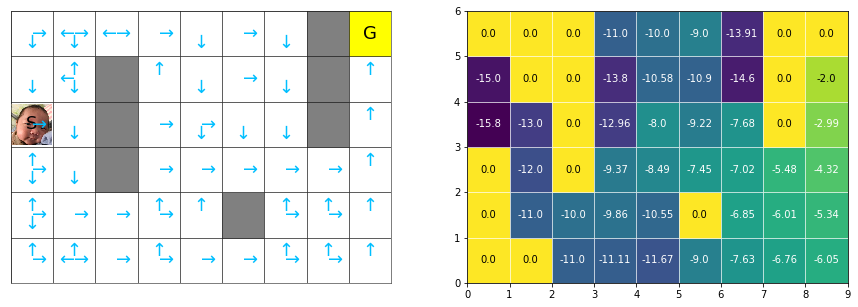

CPU times: user 4min 34s, sys: 3.12 s, total: 4min 37s
Wall time: 4min 35s


In [0]:
%%time

# print("Initialize the maze")
maze = Maze()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.learn(numEpisode=20000, learnmode="off")
maze.draw()

# Trial of solving Maze mini
Test the algorithmn with Maze_mini a simple model for maze.  

## On-policy Exploring Start
You can make quite good approximate results from ES compared to Dynamic Progamming showed below [DP github url](https://github.com/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_dynamic_programming.ipynb):
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/MazeMini_DP.png" width="600"/>  
You need more computing resource, and you may get quite different results under the same number of episodes. Because exploring start give a random $(s_0, a_0)$ that does not obey current policy $\pi$.

However, in some reality use case you cannot start at a random state to explore the episode.

**MIssion**: when have time, show q(s,a) value in maze plot. 
One value grid will be splited into four grids to show state action function values. The layout is shown below.

| column1 | colcumn2 |
|---|---|
| q(s, left) | q(s, up) |
| q(s, right) | q(s, down) |


Initialize the maze


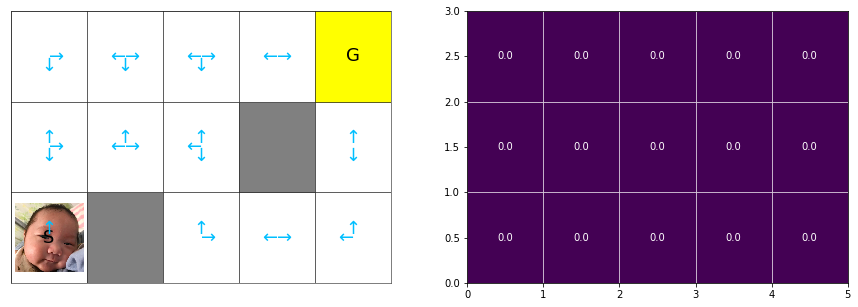

Learning
Episodes: 20000

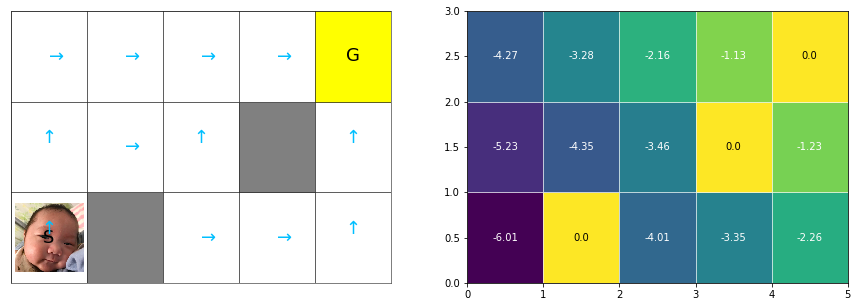

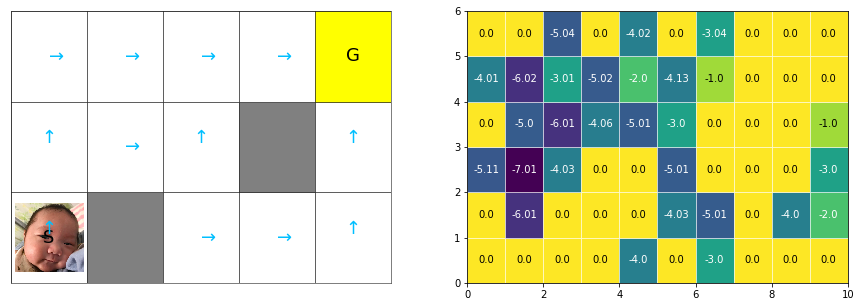

CPU times: user 16.4 s, sys: 673 ms, total: 17.1 s
Wall time: 16.5 s


In [101]:
%%time

print("Initialize the maze")
maze = Maze_mini()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.learn(numEpisode=20000, learnmode="on-est")
maze.draw()
maze.draw(setq=True)

## On-policy $\epsilon$-soft policies
In on-policy control methods the policy is generally soft, meaning that $\pi(a|s)$
for all $s \in S$ and all $a \in A(s)$, but gradually shifted closer and closer to a deterministic
optimal policy. 

According to the results, the $\epsilon$-soft policies won't perform well like ES method.

Initialize the maze


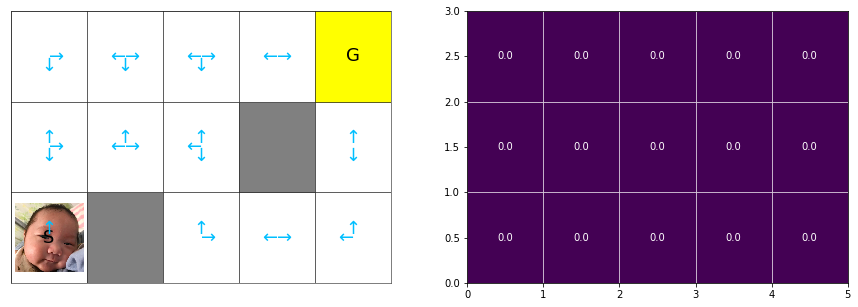

Learning
Episodes: 20000

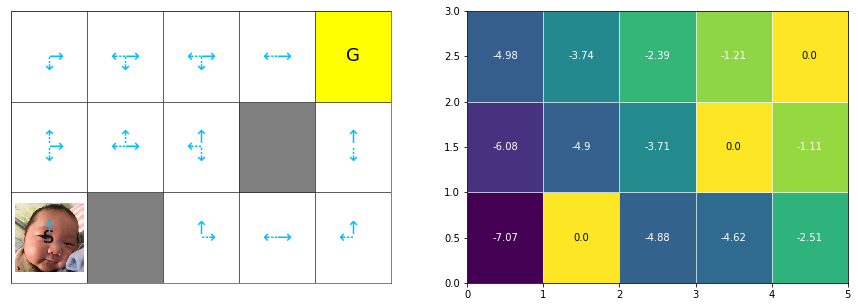

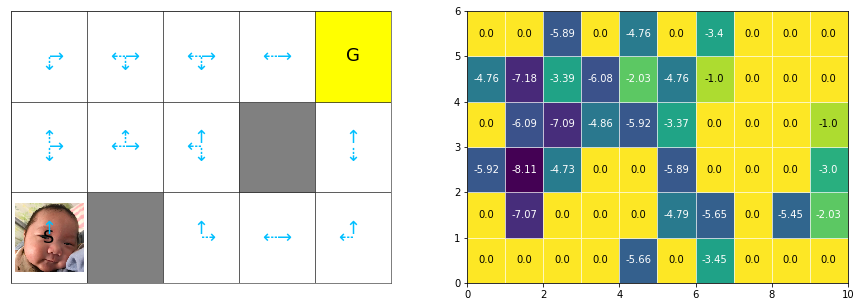

CPU times: user 26.6 s, sys: 808 ms, total: 27.4 s
Wall time: 27 s


In [102]:
%%time

print("Initialize the maze")
maze = Maze_mini()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.learn(numEpisode=20000, learnmode="on-esf", epsilon=0.2)
maze.draw()
maze.draw(setq=True)

## Off-policy
I like the style of introduction for off-policy:
> All learning control methods face a dilemma: They seek to learn action values conditional on subsequent optimal behavior, but they need to behave non-optimally in order to explore all actions (to find the optimal actions). How can they learn about the optimal policy while behaving according to an exploratory policy? The on-policy approach in the preceding section is actually a compromise—it learns action values not for the optimal policy, but for a near-optimal policy that still explores. A more straightforward approach is to use two policies, one that is learned about and that becomes the optimal policy, and one that is more exploratory and is used to generate behavior. The policy being learned about is called the target policy, and the policy used to generate behavior is called the behavior policy. In this case we say that learning is from data “off” the target policy, and the overall process is termed off-policy learning.

Initialize the maze


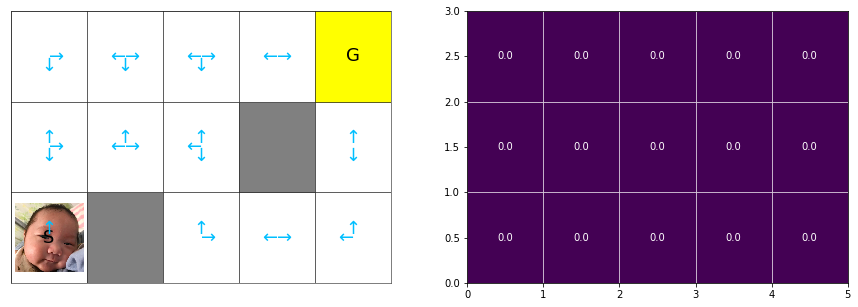

Learning
Episodes: 20000

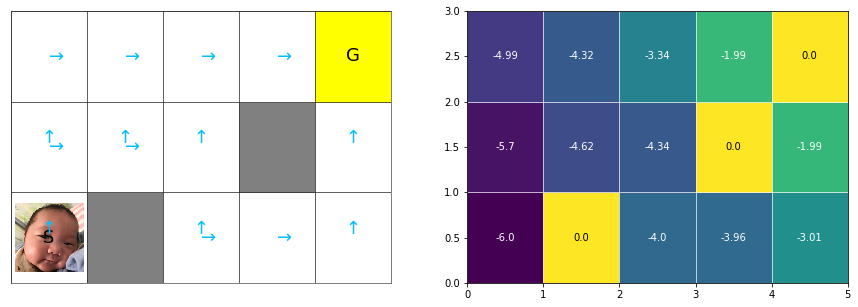

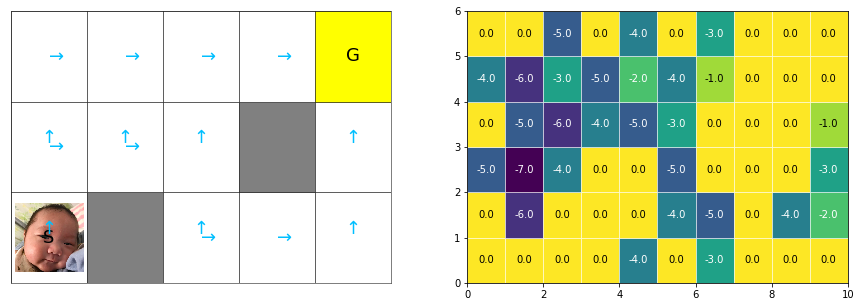

CPU times: user 47.9 s, sys: 873 ms, total: 48.7 s
Wall time: 48.4 s


In [100]:
%%time

print("Initialize the maze")
maze = Maze_mini()
maze.draw()

print("Learning")
rlmc = RL_mc(maze)
rlmc.learn(numEpisode=20000, learnmode="off")
maze.draw()
maze.draw(setq=True)

# Convergence Evaluation
Use the average of q(s,a) to check whther policy iteration is converged or not.

## Function to plot convergence situation

In [0]:
def norm_minmax(x, axis=None):
    minx = x.min(axis=axis, keepdims=True)
    maxx = x.max(axis=axis, keepdims=True)
    meanx = x.mean(axis=axis, keepdims=True)
    result = (x-minx)/(maxx-minx) if (maxx-minx) != 0 else meanx
    return result

def normalize_rows(x, axis=None):
    l2 = np.linalg.norm(x, ord = 2, axis=axis, keepdims=True)
    l2[l2==0] = 1
    return x/l2

def sample(maze, numEpisode, numSample, sumq=True):
    maze = [type(maze)() for _ in range(3)]
    rlmc = [RL_mc(maze[i]) for i in range(3)]
    avesample = [[] for _ in range(3)]
    learnmode = [
                dict(numEpisode=numEpisode, learnmode="on-est", showloop=False), 
                dict(numEpisode=numEpisode, learnmode="on-esf", epsilon=0.2, showloop=False),
                dict(numEpisode=numEpisode, learnmode="off", showloop=False)]

    for n in range(1, numSample+1):
        [maze[i].initSAP() for i in range(3)]
        [rlmc[i].learn(**learnmode[i]) for i in range(3)]
        for i in range(3):
            avesample[i].append(rlmc[i].sumq if sumq else rlmc[i].sumv)
    avesample = np.array(avesample)
    # avesample = [norm_minmax(ave) for ave in avesample]
    # avesample = [normalize_rows(ave) for ave in avesample]
    global avesample_mean, avesample_percentile
    avesample_mean = [np.nanmean(ave, axis=0) for ave in avesample]
    avesample_percentile = [np.nanpercentile(ave, [2.5, 97.5], axis=0) for ave in avesample]

def plot():
    plt.figure(figsize=(12,7))
    legend = ["on-policy: Exploring Start", "on-policy: Epsilon Soft", "off-policy: weighted sampling"]
    cmap = plt.get_cmap('prism') #'prism' # 'brg'
    color=cmap(np.linspace(0,1,3))
    dataset = {lg: 
            [
                ( avesample_mean[i], avesample_percentile[i][0], avesample_percentile[i][1] ),
                color[i]
                ] 
            for i, lg in enumerate(legend)}
    for lg, [(mean, lower, upper), color] in dataset.items():
        plt.plot(mean, label=lg, color=color, ls="-", lw=1.2, alpha=1.0)
        plt.plot(lower, color=color, ls="--", lw=1.2, alpha=1.0)
        plt.plot(upper, color=color, ls="--", lw=1.2, alpha=1.0)
        plt.fill_between(range(numEpisode), lower, upper, color=color, alpha=0.1, label=lg + " 95% Confidence interval", zorder=1)
    ax = plt.gca()
    ax.set_xlabel("Number of episodes", fontsize=16)
    ax.set_ylabel("Sum of q(s, a)", fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(loc='lower center', fontsize=13, bbox_to_anchor=(0.5, 1), shadow=True, ncol=2)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

## Maze model (5x3=15)

CPU times: user 32min 43s, sys: 559 ms, total: 32min 44s
Wall time: 32min 46s


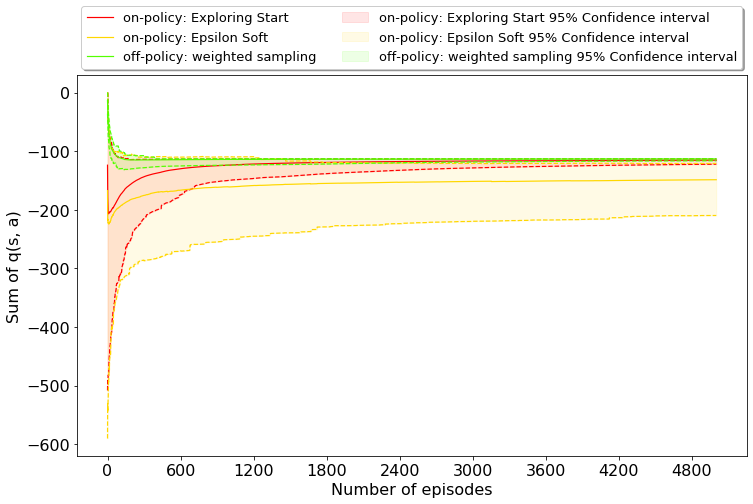

In [111]:
%%time
maze = Maze_mini()
numEpisode = 5000
numSample = 100
sample(maze, numEpisode, numSample)
plot()

## Maze model (9x6=54)

CPU times: user 3h 16min 43s, sys: 2.66 s, total: 3h 16min 46s
Wall time: 3h 16min 56s


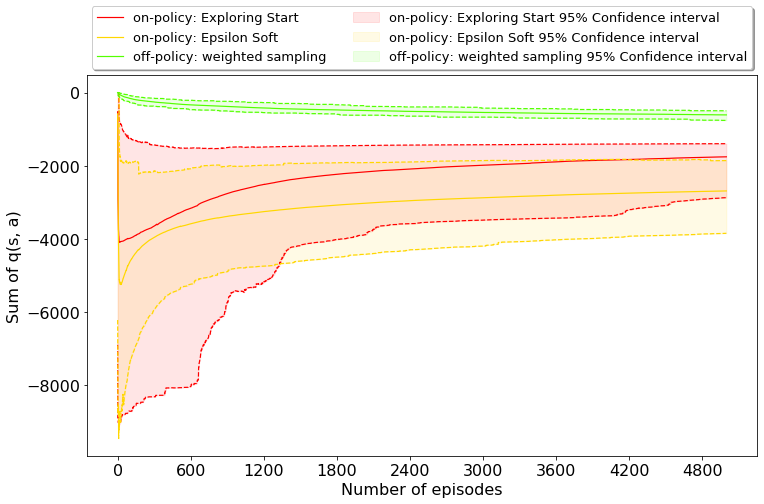

In [112]:
%%time
maze = Maze()
numEpisode = 5000
numSample = 100
sample(maze, numEpisode, numSample)
plot()

# Summary

Difference are between the Monte Carlo methods and the DP methods in two major ways. 

1. First, they operate on sample experience, and thus can be used for direct learning without a model. 
1. Second, they do not bootstrap. That is, they do not update their value estimates on the basis of other value estimates. 

These two differences are not tightly linked, and can be separated. 

In the next chapter we consider methods that learn from experience, like Monte Carlo methods, but also bootstrap, like DP methods.